## Optimization

Libraries import

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data
import numpy as np
import nnfs
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from tools.nets import Layer_Dense

np.random.seed(42)
nnfs.init()

Functions import

In [51]:
Layer_Dense

tools.nets.Layer_Dense

### Vertical Dataset

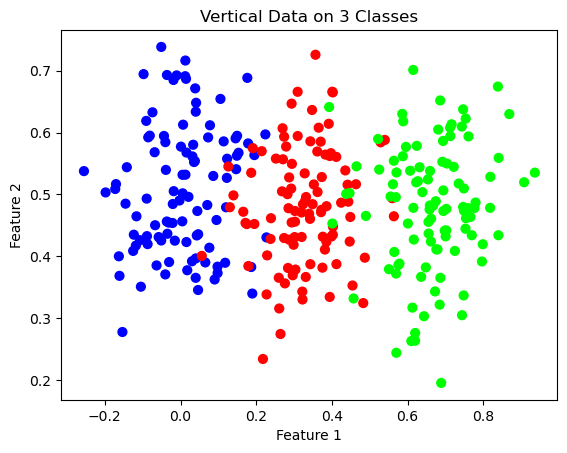

In [52]:
X, y = vertical_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.title('Vertical Data on 3 Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [53]:
print("Type:", type(X), type(y))
print('Shape:')
print(X.shape, y.shape)

Type: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Shape:
(300, 2) (300,)


Convert to torch tensor

In [54]:
X_torch = torch.tensor(X, dtype=torch.float32).cuda()
y_torch = torch.tensor(y, dtype=torch.float32).cuda()

In [55]:
model_torch = [
    Layer_Dense(2, 3, activation='relu', backend='torch'), # 2 inputs, 3 hidden nodes
    Layer_Dense(3, 3, activation='softmax', backend='torch') # 3 hidden nodes, 3 outputs
]
model_torch[0].weights, model_torch[0].biases

(tensor([[-0.0058,  0.0166,  0.0104],
         [ 0.0079, -0.0043, -0.0003]], device='cuda:0'),
 tensor([[0., 0., 0.]], device='cuda:0'))

In [56]:
model_torch[0].weights.shape, model_torch[0].biases.shape

(torch.Size([2, 3]), torch.Size([1, 3]))

In [57]:
torch.randn(model_torch[0].weights.shape)

tensor([[ 0.5703, -0.2048,  1.2389],
        [ 0.4193,  0.5503, -0.5588]])

Optimization without loss function

We initialized the loss to a large value and will decrease it when a new, lower, loss is found. We
are also copying weights and biases (​copy()​ ensures a full copy instead of a reference to the
object). Now we iterate as many times as desired, pick random values for weights and biases, and
save the weights and biases if they generate the lowest-seen loss

In [58]:
# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = model_torch[0].weights.clone()
best_dense1_biases = model_torch[0].biases.clone()
best_dense2_weights = model_torch[1].weights.clone()
best_dense2_biases = model_torch[1].biases.clone()

# for iteration in range(10000):
for iteration in range(10000):
    # Random parameter initialization
    for i, layer in enumerate(model_torch):
        layer.weights = 0.05 * torch.randn(layer.weights.shape).cuda()
        layer.biases = 0.05 * torch.randn(layer.biases.shape).cuda()
    
    # Perform a forward pass of the training data through each layer
    x = X_torch
    for layer in model_torch:
        x = layer.forward(x)
    model_output = x
    loss = layer.backend.categorical_cross_entropy(model_output, y_torch)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = torch.argmax(model_output, axis=1)
    accuracy = torch.mean((predictions==y_torch).float())
    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        current_best_params = {} # Temporary dict for this iteration's best params
        print('New set of weights found, iteration:', iteration, 'loss:', loss, 'acc:', accuracy)
        for j, layer in enumerate(model_torch):
            current_best_params[f"Layer {j}"] = {
                'weights': layer.weights.clone(),
                'biases': layer.biases.clone()
                # f"Layer {j} "+'weights': layer.weights.clone().detach(),
                # f"Layer {j} "+'biases': layer.biases.clone().detach()
            }
        # Update the overall best parameters dictionary
        best_model_params = current_best_params
        
        lowest_loss = loss
    # print("Iteration:", iteration, "Loss:", loss.item())

# After the loop, best_model_params will hold the weights/biases from the iteration with the lowest loss
# You can now use best_model_params, e.g., load them back into the model or save to a file
# Example: torch.save(best_model_params, 'best_random_search_model.pth')
# print(f"\nFinished search. Lowest loss found: {lowest_loss}")
# print(f"Best parameters stored in best_model_params dictionary with keys: {list(best_model_params.keys())}")

New set of weights found, iteration: 0 loss: tensor(1.0986, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 1 loss: tensor(1.0985, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 3 loss: tensor(1.0977, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 189 loss: tensor(1.0972, device='cuda:0') acc: tensor(0.4233, device='cuda:0')
New set of weights found, iteration: 514 loss: tensor(1.0971, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 1162 loss: tensor(1.0966, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 1208 loss: tensor(1.0966, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 7421 loss: tensor(1.0964, device='cuda:0') acc: tensor(0.3333, device='cuda:0')
New set of weights found, iteration: 9912 loss: tensor(1.0960, device='cuda

In [59]:
best_model_params

{'Layer 0': {'weights': tensor([[-0.1038,  0.1083, -0.0467],
          [ 0.0115,  0.0271, -0.0429]], device='cuda:0'),
  'biases': tensor([[ 0.0373,  0.0541, -0.0475]], device='cuda:0')},
 'Layer 1': {'weights': tensor([[-0.0004,  0.0027, -0.0642],
          [-0.1777, -0.1143,  0.0251],
          [ 0.0029, -0.0554, -0.0063]], device='cuda:0'),
  'biases': tensor([[ 0.0370, -0.0056, -0.0125]], device='cuda:0')}}

In [60]:
torch.clamp(model_output, 1e-15, 1 - 1e-15).min(), torch.clamp(model_output, 1e-15, 1 - 1e-15).max()

(tensor(0.3255, device='cuda:0'), tensor(0.3379, device='cuda:0'))

Even with this basic dataset, we see that randomly searching for weight and bias combinations
will take far too long to be an acceptable method. Another idea might be, instead of setting
parameters with randomly-chosen values each iteration, apply a fraction of these values to
parameters. With this, weights will be updated from what currently yields us the lowest loss
instead of aimlessly randomly. If the adjustment decreases loss, we will make it the new point to
adjust from. If loss instead increases due to the adjustment, then we will revert to the previous
point. Using similar code from earlier, we will first change from randomly selecting weights and
biases to randomly ​adjusting​ them:

In [61]:
# Helper variables
lowest_loss = 9999999 # some initial value
best_dense1_weights = model_torch[0].weights.clone()
best_dense1_biases = model_torch[0].biases.clone()
best_dense2_weights = model_torch[1].weights.clone()
best_dense2_biases = model_torch[1].biases.clone()

# for iteration in range(10000):
for iteration in range(10000):
    # Random parameter initialization
    for layer in model_torch:
        layer.weights += 0.05 * torch.randn(layer.weights.shape).cuda()
        layer.biases += 0.05 * torch.randn(layer.biases.shape).cuda()
    
    # Perform a forward pass of the training data through each layer
    x = X_torch
    for layer in model_torch:
        x = layer.forward(x)
    model_output = x
    loss = layer.backend.categorical_cross_entropy(model_output, y_torch)
    
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = torch.argmax(model_output, axis=1)
    accuracy = torch.mean((predictions==y_torch).float())
    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        current_best_params = {} # Temporary dict for this iteration's best params
        # print('New set of weights found, iteration:', iteration, 'loss:', loss, 'acc:', accuracy)
        for j, layer in enumerate(model_torch):
            current_best_params[f"Layer {j}"] = {
                'weights': layer.weights.clone(),
                'biases': layer.biases.clone()
                # f"Layer {j} "+'weights': layer.weights.clone().detach(),
                # f"Layer {j} "+'biases': layer.biases.clone().detach()
            }
        # Update the overall best parameters dictionary
        best_model_params = current_best_params
        
        lowest_loss = loss
    else:
        for k, layer in enumerate(model_torch):
            layer.weights = current_best_params[f"Layer {k}"]['weights'].clone()
            layer.biases = current_best_params[f"Layer {k}"]['biases'].clone()

print(f'Best at iteration {iteration}: loss={loss:.4f}, accuracy={accuracy:.4f}')            
    # print("Iteration:", iteration, "Loss:", loss.item())

# After the loop, best_model_params will hold the weights/biases from the iteration with the lowest loss
# You can now use best_model_params, e.g., load them back into the model or save to a file
# Example: torch.save(best_model_params, 'best_random_search_model.pth')
# print(f"\nFinished search. Lowest loss found: {lowest_loss}")
# print(f"Best parameters stored in best_model_params dictionary with keys: {list(best_model_params.keys())}")

Best at iteration 9999: loss=0.1727, accuracy=0.9267


In [62]:
model_torch

In [63]:
# Initialize best parameters and loss
lowest_loss = float('inf')
current_best_params = {}

# Training loop
for iteration in range(10000):
    # Random weight adjustment for each layer
    for layer in model_torch:
        layer.weights += 0.05 * torch.randn(layer.weights.shape, device='cuda:0')
        layer.biases += 0.05 * torch.randn(layer.biases.shape, device='cuda:0')
    
    # Forward pass
    output = X_torch
    for layer in model_torch:
        output = layer.forward(output)
    
    # Calculate loss and accuracy
    loss = model_torch[-1].backend.categorical_cross_entropy(output, y_torch) # Use the last layer's backend for loss calculation (index -1)
    predictions = torch.argmax(output, dim=1)
    accuracy = torch.mean((predictions == y_torch).float())
    
    # Update best parameters if loss improves
    if loss < lowest_loss:
        # print(f'New best at iteration {iteration}: loss={loss:.4f}, accuracy={accuracy:.4f}')
        
        # Store current parameters
        current_best_params = {
            f'Layer {i}': {
                'weights': layer.weights.clone(),
                'biases': layer.biases.clone()
            }
            for i, layer in enumerate(model_torch)
        }
        
        lowest_loss = loss
    else:
        # Revert to best parameters if no improvement
        for i, layer in enumerate(model_torch):
            layer.weights = current_best_params[f'Layer {i}']['weights'].clone()
            layer.biases = current_best_params[f'Layer {i}']['biases'].clone()

print(f'New best at iteration {iteration}: loss={loss:.4f}, accuracy={accuracy:.4f}')            


New best at iteration 9999: loss=0.1772, accuracy=0.9200


### Spiral Dataset

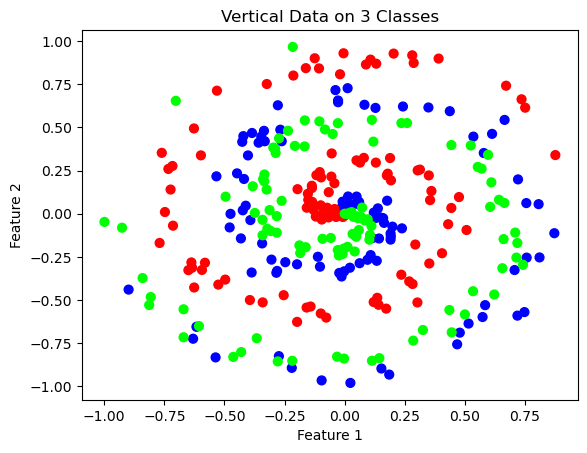

In [64]:
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.title('Vertical Data on 3 Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [65]:
print("Type:", type(X), type(y))
print('Shape:')
print(X.shape, y.shape)

Type: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Shape:
(300, 2) (300,)


Convert to torch tensor

In [66]:
X_torch = torch.tensor(X, dtype=torch.float32).cuda()
y_torch = torch.tensor(y, dtype=torch.float32).cuda()

In [67]:
# Initialize best parameters and loss
lowest_loss = float('inf')
current_best_params = {}

# Training loop
for iteration in range(10000):
    # Random weight adjustment for each layer
    for layer in model_torch:
        layer.weights += 0.05 * torch.randn(layer.weights.shape, device='cuda:0')
        layer.biases += 0.05 * torch.randn(layer.biases.shape, device='cuda:0')
    
    # Forward pass
    output = X_torch
    for layer in model_torch:
        output = layer.forward(output)
    
    # Calculate loss and accuracy
    loss = model_torch[-1].backend.categorical_cross_entropy(output, y_torch) # Use the last layer's backend for loss calculation (index -1)
    predictions = torch.argmax(output, dim=1)
    accuracy = torch.mean((predictions == y_torch).float())
    
    # Update best parameters if loss improves
    if loss < lowest_loss:
        # print(f'New best at iteration {iteration}: loss={loss:.4f}, accuracy={accuracy:.4f}')
        
        # Store current parameters
        current_best_params = {
            f'Layer {i}': {
                'weights': layer.weights.clone(),
                'biases': layer.biases.clone()
            }
            for i, layer in enumerate(model_torch)
        }
        
        lowest_loss = loss
    else:
        # Revert to best parameters if no improvement
        for i, layer in enumerate(model_torch):
            layer.weights = current_best_params[f'Layer {i}']['weights'].clone()
            layer.biases = current_best_params[f'Layer {i}']['biases'].clone()

print(f'Best at iteration {iteration}: loss={loss:.4f}, accuracy={accuracy:.4f}')

Best at iteration 9999: loss=1.0500, accuracy=0.3900


This training session ended with almost no progress. Loss decreased slightly and accuracy is
barely above the initial value. Later, we’ll learn that the most probable reason for this is called a
local minimum of loss. The data complexity is also not irrelevant here. It turns out hard problems
are hard for a reason, and we need to approach this problem more intelligently.